In [ ]:
from zipfile import ZipFile

# Path to the uploaded zip file
zip_path = '/content/archive (5).zip'

# Directory to extract to
extract_path = '/content/dataset'

# Unzipping
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset unzipped successfully!")


Dataset unzipped successfully!


In [ ]:
import os
import random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Set seed for reproducibility
torch.manual_seed(42)

# Define preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 112)),  # Resize preserving aspect ratio manually
    transforms.Pad(padding=(56, 0), fill=0),  # Pad to make it 224x224 (center padding)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

class MangoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_names = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.class_names)}

        for cls_name in self.class_names:
            cls_folder = os.path.join(root_dir, cls_name)
            for img_name in os.listdir(cls_folder):
                self.image_paths.append(os.path.join(cls_folder, img_name))
                self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

# Load dataset
dataset = MangoDataset(root_dir='/content/dataset', transform=transform)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


In [ ]:
import timm
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ViT pre-trained model
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Modify head
model.head = nn.Linear(model.head.in_features, len(dataset.class_names))

model = model.to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch [1/5], Train Accuracy: 37.19%
Validation Accuracy: 65.12%
Epoch [2/5], Train Accuracy: 78.19%
Validation Accuracy: 87.00%
Epoch [3/5], Train Accuracy: 92.16%
Validation Accuracy: 91.38%
Epoch [4/5], Train Accuracy: 94.19%
Validation Accuracy: 92.62%
Epoch [5/5], Train Accuracy: 92.97%
Validation Accuracy: 95.00%


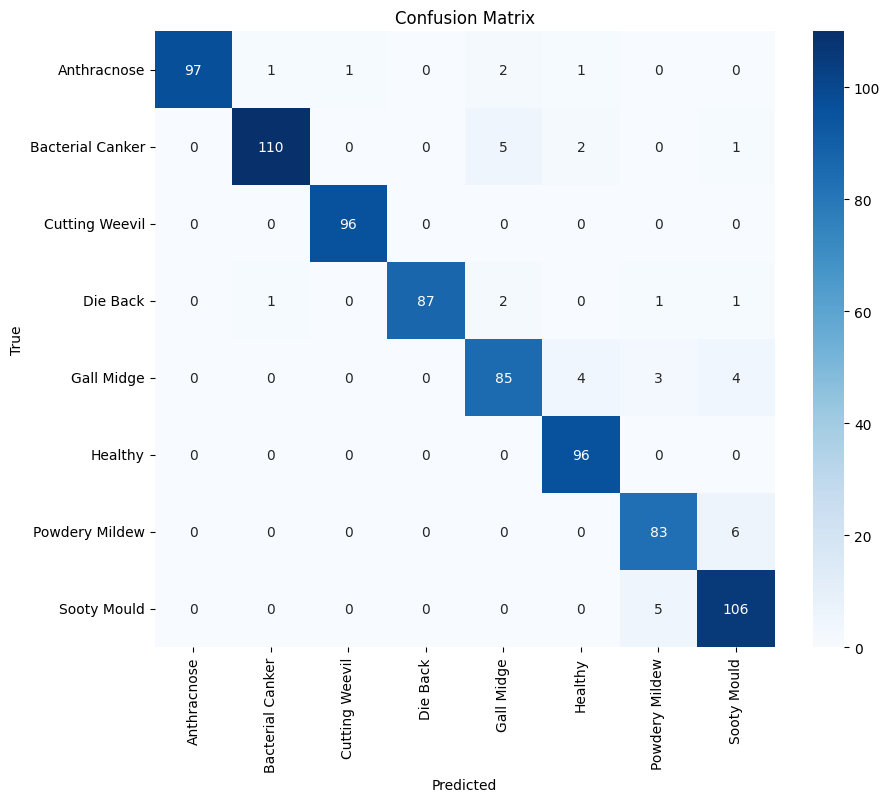

                  precision    recall  f1-score   support

     Anthracnose       1.00      0.95      0.97       102
Bacterial Canker       0.98      0.93      0.96       118
  Cutting Weevil       0.99      1.00      0.99        96
        Die Back       1.00      0.95      0.97        92
      Gall Midge       0.90      0.89      0.89        96
         Healthy       0.93      1.00      0.96        96
  Powdery Mildew       0.90      0.93      0.92        89
     Sooty Mould       0.90      0.95      0.93       111

        accuracy                           0.95       800
       macro avg       0.95      0.95      0.95       800
    weighted avg       0.95      0.95      0.95       800



In [ ]:
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = 100. * correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Train Accuracy: {train_acc:.2f}%")

    # Validation
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_acc = 100. * correct / total
    print(f"Validation Accuracy: {val_acc:.2f}%")

    if epoch == epochs - 1:  # After final epoch
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.class_names, yticklabels=dataset.class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

        # Classification report
        print(classification_report(all_labels, all_preds, target_names=dataset.class_names))


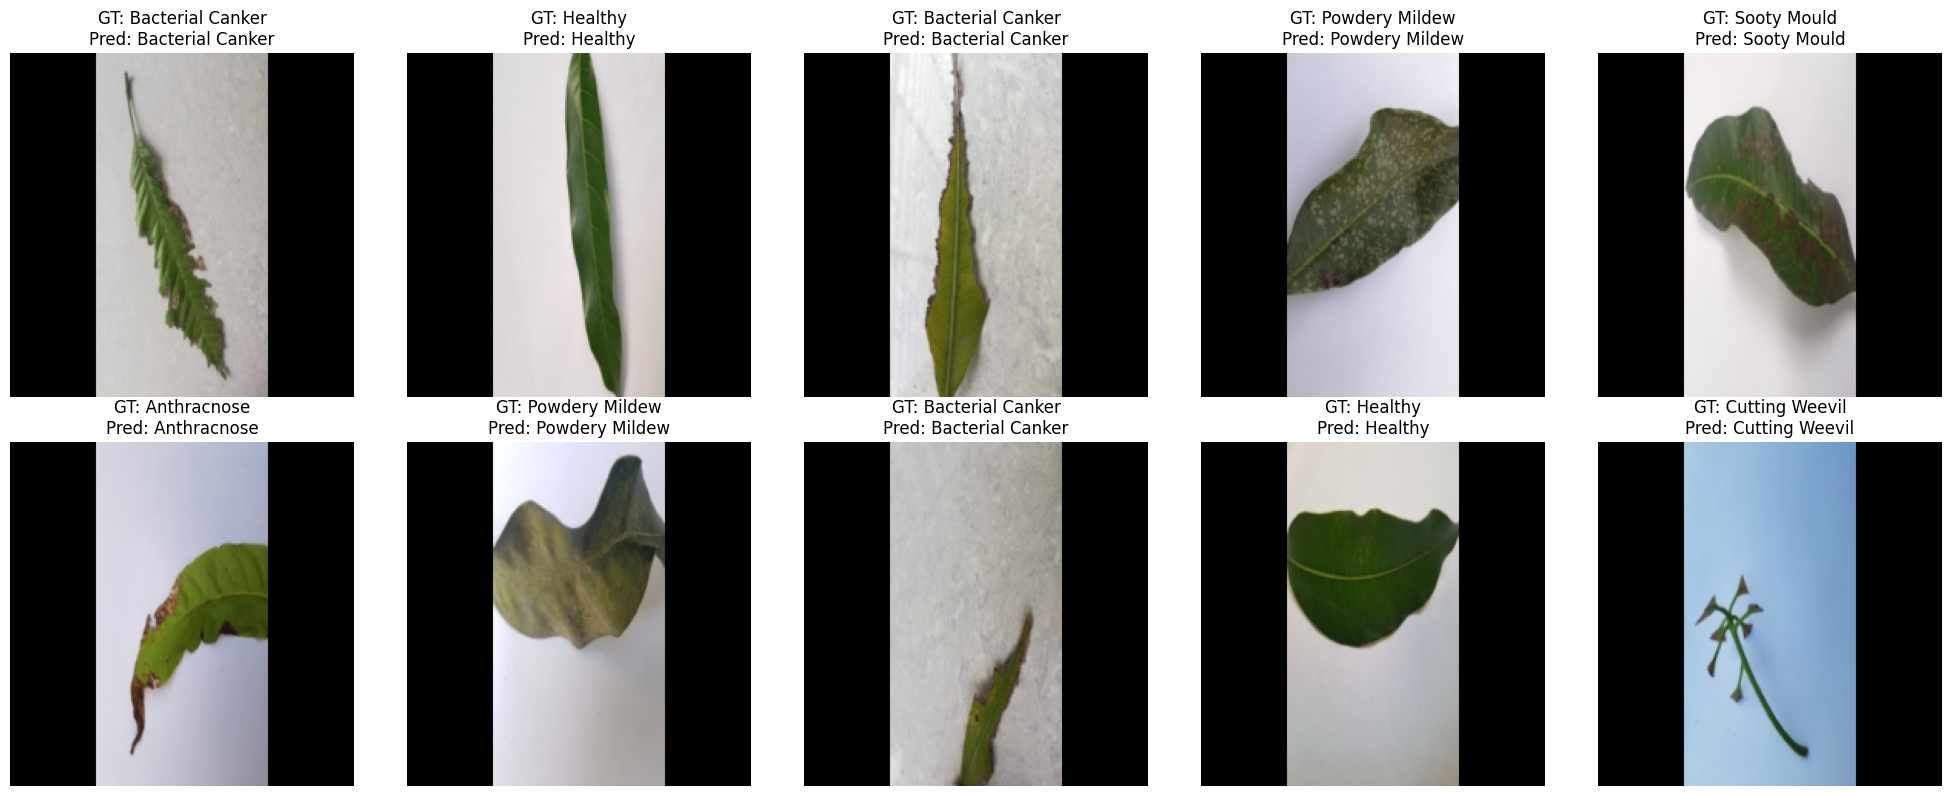

In [ ]:
# Randomly select 10 samples
model.eval()
samples = random.sample(range(len(val_dataset)), 10)

plt.figure(figsize=(20, 8))
for i, idx in enumerate(samples):
    img, label = val_dataset[idx]
    img_input = img.unsqueeze(0).to(device)
    pred = model(img_input).argmax(dim=1).item()

    img = img.permute(1, 2, 0).cpu()  # CHW to HWC
    img = img * 0.5 + 0.5  # Unnormalize
    img = img.numpy()

    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"GT: {dataset.class_names[label]}\nPred: {dataset.class_names[pred]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


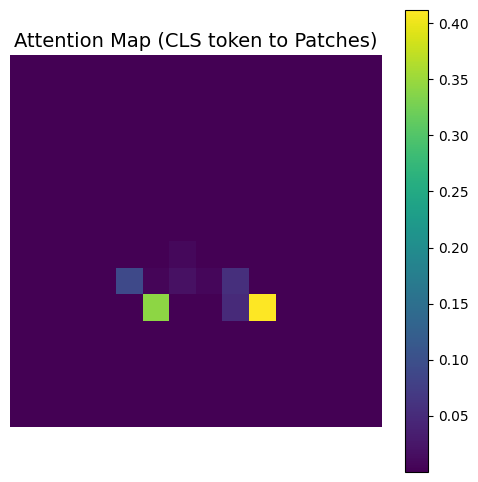

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_attention_easy(model, image_tensor):
    model.eval()

    attn_maps = []

    attn_module = model.blocks[5].attn  # <--- Fetch the attention block properly
    num_heads = attn_module.qkv.out_features // attn_module.qkv.in_features  # Derive num_heads correctly

    def hook_fn_qkv(module, input, output):
        B, N, C = output.shape

        qkv = output.reshape(B, N, 3, num_heads, C // (3 * num_heads)).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * (1.0 / np.sqrt(k.size(-1)))
        attn = attn.softmax(dim=-1)

        attn_maps.append(attn)

    # Register hook on qkv
    handle = attn_module.qkv.register_forward_hook(hook_fn_qkv)

    with torch.no_grad():
        _ = model(image_tensor.unsqueeze(0))  # Add batch dimension

    handle.remove()

    # Now process attention
    attn = attn_maps[0]  # (batch_size, num_heads, tokens, tokens)

    attn = attn[0, 0]  # Take first batch, first head (tokens x tokens)

    cls_attn = attn[0, 1:]  # Attention from [CLS] token to patches

    num_patches = cls_attn.size(0)
    grid_size = int(np.sqrt(num_patches))
    cls_attn = cls_attn.reshape(grid_size, grid_size).cpu().numpy()

    plt.figure(figsize=(6, 6))
    plt.imshow(cls_attn, cmap='viridis')
    plt.colorbar()
    plt.title('Attention Map (CLS token to Patches)', fontsize=14)
    plt.axis('off')
    plt.show()

# --- Usage ---
chosen_img = images[0]   # Select an image tensor
visualize_attention_easy(model, chosen_img)
